<a href="https://colab.research.google.com/github/AyushSrivastava27/Brain-Tumor-Segmentation/blob/main/brain_tumour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumour Detection Using MRI Images

## 1. Problem Definition

Classification and Segmentation of Brain Tumours from MR Images Using Deep Transfer Learning.

## 2. Data

The data we're using is for Kaggle's Brain Tumor MRI Dataset

https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

This dataset is a combination of the following three datasets:
- figshare
- SARTAJ dataset
- Br35H


In [ ]:
# Get GPU name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2d3f08bd-06f3-e4d5-85bb-b493042c694e)


In [ ]:
# importing libraries

import tensorflow as tf
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [ ]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.15.0


### Exploring our Dataset

In [ ]:
train_dir = "drive/MyDrive/Brain Tumour Detection/archive/Training/"
test_dir = "drive/MyDrive/Brain Tumour Detection/archive/Testing"

In [ ]:
# Get the class names for our multi-class dataset
data_dir = pathlib.Path(train_dir)
class_names = np.array([item.name for item in data_dir.glob('*')])
print(class_names)

['glioma' 'meningioma' 'notumor' 'pituitary']


In [ ]:
def extract_class_info(dataset_path):
    class_names = []
    class_counts = []

    for class_folder in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_folder)

        if os.path.isdir(class_path):
            class_names.append(class_folder)
            class_counts.append(len(os.listdir(class_path)))

    return class_names, class_counts

train_class_names, train_class_counts = extract_class_info(train_dir)
test_class_names, test_class_counts = extract_class_info(test_dir)

# Display the information
print("Train Dataset:")
for name, count in zip(train_class_names, train_class_counts):
    print(f"Class: {name}, Count: {count}")

print("\nTest Dataset:")
for name, count in zip(test_class_names, test_class_counts):
    print(f"Class: {name}, Count: {count}")

Train Dataset:
Class: glioma, Count: 1321
Class: meningioma, Count: 1339
Class: notumor, Count: 1595
Class: pituitary, Count: 1467

Test Dataset:
Class: glioma, Count: 300
Class: meningioma, Count: 306
Class: pituitary, Count: 300
Class: notumor, Count: 405


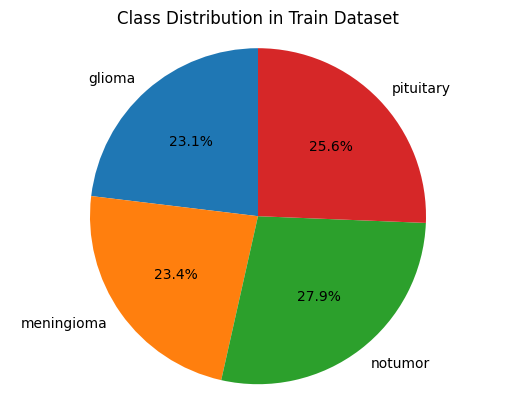

In [ ]:
# plotting our training dataset

fig, ax = plt.subplots()
ax.pie(train_class_counts, labels=train_class_names, autopct='%1.1f%%', startangle=90)
ax.axis('equal')

plt.title('Class Distribution in Train Dataset')
plt.show()

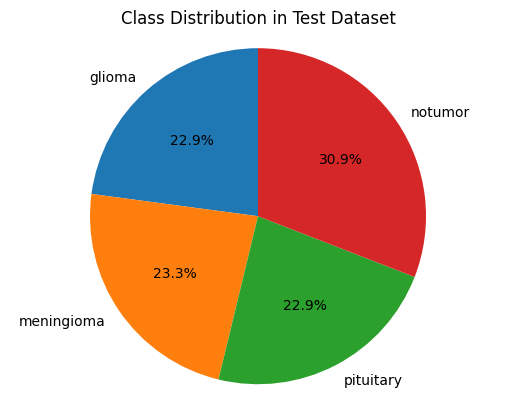

In [ ]:
# plotting our testing dataset

fig, ax = plt.subplots()
ax.pie(test_class_counts, labels=test_class_names, autopct='%1.1f%%', startangle=90)
ax.axis('equal')

plt.title('Class Distribution in Test Dataset')
plt.show()

### Visualization and Analysis

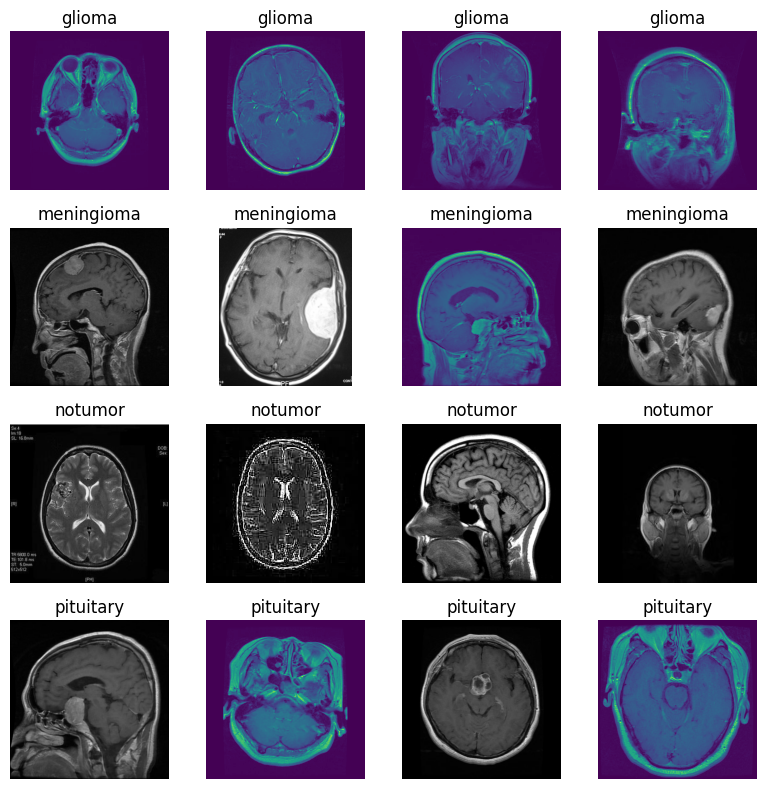

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def plot_random_images(target_dir, num_images_per_class=4, img_size=(8, 8)):
    classes = os.listdir(target_dir)
    plt.figure(figsize=img_size)

    for i, target_class in enumerate(classes):
        target_folder = os.path.join(target_dir, target_class)
        random_images = random.sample(os.listdir(target_folder), num_images_per_class)

        for j, random_image in enumerate(random_images):
            img_path = os.path.join(target_folder, random_image)
            img = mpimg.imread(img_path)

            plt.subplot(len(classes), num_images_per_class, i * num_images_per_class + j + 1)
            plt.imshow(img)
            plt.title(target_class)
            plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
train_dir = "drive/MyDrive/Brain Tumour Detection/archive/Training/"

# Plot 4 random images for each class
plot_random_images(train_dir, num_images_per_class=4)


In [ ]:
# function to view an random image

import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir + '/' + target_class
  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}")

  return img

Image shape: (512, 512)


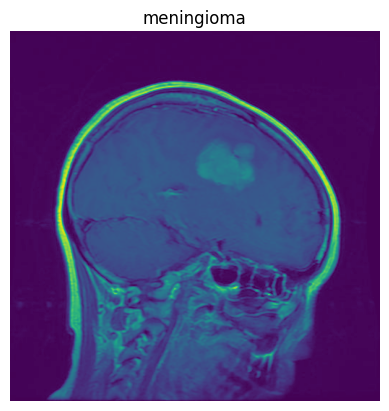

In [ ]:
# view a random image from the training dataset
import random
img = view_random_image(target_dir = train_dir,
                        target_class = random.choice(class_names))

In [ ]:
# checking out our image
img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
# checking the shape of our image
img.shape # (width, height, color)

(512, 512)

### Preprocessing our Data

In [ ]:
# Setup data inputs

IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 5722 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [ ]:
# Helper Functions

### We are creating a bunch of helpful functions

# Create a function to import an image and resize it to be able to be used with our model

def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Make a function to predict on images and plot them
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


### Creating modelling Callbacks

In [ ]:
# Setting up EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Creating ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

### Fine-Tuning Deep Learning Models for Multimodal Brain Tumors

1. EfficientNetB0
2. ResNet50V2
3. InceptionV3
4. DenseNet121

In [ ]:
# Importing the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # removing for EfficientNetB0
], name ="data_augmentation")


In [ ]:
from tensorflow.keras import layers

# Creating base model
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # setting base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_1 = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# What layers in the model are trainable?
for layer in model_1.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
pooling_layer True
dense True
softmax_float32 True


In [ ]:
# Checking which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# compile model with lower learning rate

model_1.compile(loss="categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
              metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score(average='macro')])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
 softmax_float32 (Activatio  (None, 4)                 0         
 n)                                                              
                                                             

In [ ]:
# Start to fine-tune
history_1 = model_1.fit(train_data,
                      epochs=100,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      # validation_steps=int(0.15 * len(test_data)),
                      callbacks=[create_tensorboard_callback("training_logs", "efficientb0_all_data_fine_tuning"),
                                  model_checkpoint,
                                  early_stopping,
                                  reduce_lr])

Saving TensorBoard log files to: training_logs/efficientb0_all_data_fine_tuning/20240105-055056
Epoch 1/100
179/179 [==============================] - 1042s 5s/step - loss: 0.5444 - accuracy: 0.7978 - precision: 0.8854 - recall: 0.6966 - f1_score: 0.7875 - val_loss: 0.3789 - val_accuracy: 0.8551 - val_precision: 0.8736 - val_recall: 0.8223 - val_f1_score: 0.8499 - lr: 1.0000e-04
Epoch 2/100
179/179 [==============================] - 19s 104ms/step - loss: 0.2750 - accuracy: 0.8971 - precision: 0.9105 - recall: 0.8841 - f1_score: 0.8929 - val_loss: 0.3095 - val_accuracy: 0.8780 - val_precision: 0.8921 - val_recall: 0.8574 - val_f1_score: 0.8700 - lr: 1.0000e-04
Epoch 3/100
179/179 [==============================] - 21s 116ms/step - loss: 0.2186 - accuracy: 0.9215 - precision: 0.9306 - recall: 0.9110 - f1_score: 0.9179 - val_loss: 0.2646 - val_accuracy: 0.8986 - val_precision: 0.9046 - val_recall: 0.8894 - val_f1_score: 0.8926 - lr: 1.0000e-04
Epoch 4/100
179/179 [=======================

In [ ]:
# Evaluate fine-tuned model on the whole test dataset
results_1 = model_1.evaluate(test_data)
results_1

41/41 [==============================] - 3s 81ms/step - loss: 0.0609 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9756 - f1_score: 0.9752


[0.06092110648751259,
 0.9771167039871216,
 0.9770817160606384,
 0.9755911231040955,
 0.975249171257019]

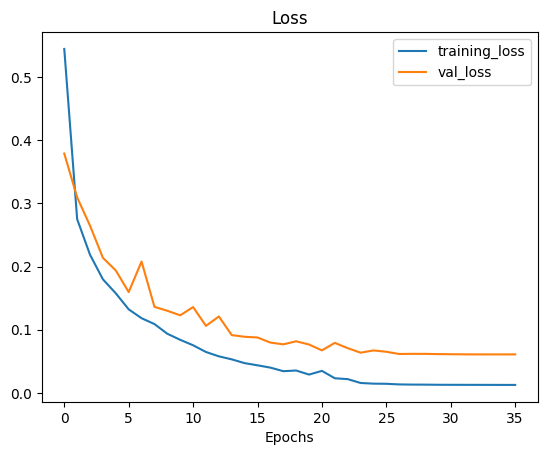

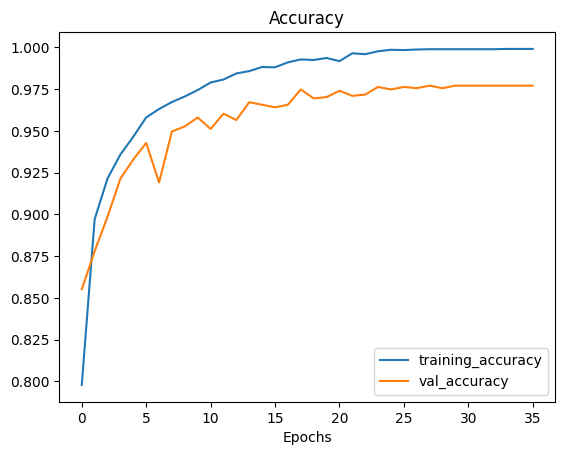

In [ ]:
plot_loss_curves(history_1)

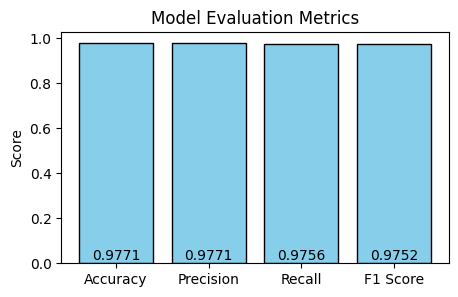

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [results_1[1], results_1[2], results_1[3], results_1[4]]

fig, ax = plt.subplots(figsize=(5, 3))

bars = ax.bar(np.arange(len(metrics)), values, color='skyblue', edgecolor='black')

ax.set_xticks(np.arange(len(metrics)))
ax.set_xticklabels(metrics)

# Display values at the bottom of each bar
for bar, value in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width() / 2, 0, f'{value:.4f}', ha='center', va='bottom', color='black', fontsize=10)

ax.set_ylabel('Score')
ax.set_title('Model Evaluation Metrics')

plt.show()

In [ ]:
# Importing the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  layers.Rescaling(1./255) # keeping for ResNet50V2
], name ="data_augmentation")

In [ ]:
from tensorflow.keras import layers

# Creating base model
input_shape = (224, 224, 3)

base_model = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False)
base_model.trainable = False

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_2 = tf.keras.Model(inputs, outputs)

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# What layers in the model are trainable?
for layer in model_2.layers:
  print(layer.name, layer.trainable)

input_layer True
resnet50v2 True
pooling_layer True
dense_1 True
softmax_float32 True


In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [ ]:
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score(average='macro')])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048   23564800  
                             )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 2048)              0         
 gePooling2D)                                                    
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                                 
 softmax_float32 (Activatio  (None, 4)                 0         
 n)                                                              
                                                           

In [ ]:
history_2 = model_2.fit(train_data,
                      epochs=100,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      # validation_steps=int(0.15 * len(test_data)),
                      callbacks=[create_tensorboard_callback("training_logs", "resnet50v2_all_data_fine_tuning"),
                                  model_checkpoint,
                                  early_stopping,
                                  reduce_lr])

Saving TensorBoard log files to: training_logs/resnet50v2_all_data_fine_tuning/20240105-062309
Epoch 1/100
179/179 [==============================] - 35s 151ms/step - loss: 5.4876 - accuracy: 0.5743 - precision_1: 0.5769 - recall_1: 0.5704 - f1_score: 0.5674 - val_loss: 2.2832 - val_accuracy: 0.6674 - val_precision_1: 0.6695 - val_recall_1: 0.6629 - val_f1_score: 0.6340 - lr: 1.0000e-04
Epoch 2/100
179/179 [==============================] - 21s 114ms/step - loss: 1.1385 - accuracy: 0.7588 - precision_1: 0.7629 - recall_1: 0.7552 - f1_score: 0.7517 - val_loss: 1.1473 - val_accuracy: 0.7437 - val_precision_1: 0.7492 - val_recall_1: 0.7407 - val_f1_score: 0.7403 - lr: 1.0000e-04
Epoch 3/100
179/179 [==============================] - 23s 124ms/step - loss: 0.8457 - accuracy: 0.8055 - precision_1: 0.8109 - recall_1: 0.8020 - f1_score: 0.7992 - val_loss: 0.9740 - val_accuracy: 0.8063 - val_precision_1: 0.8138 - val_recall_1: 0.8032 - val_f1_score: 0.7922 - lr: 1.0000e-04
Epoch 4/100
179/179 

In [ ]:
results_2 = model_2.evaluate(test_data)
results_2

41/41 [==============================] - 4s 86ms/step - loss: 0.3247 - accuracy: 0.9153 - precision_1: 0.9158 - recall_1: 0.9123 - f1_score: 0.9095


[0.32468563318252563,
 0.9153317809104919,
 0.915773332118988,
 0.9122806787490845,
 0.9095076322555542]

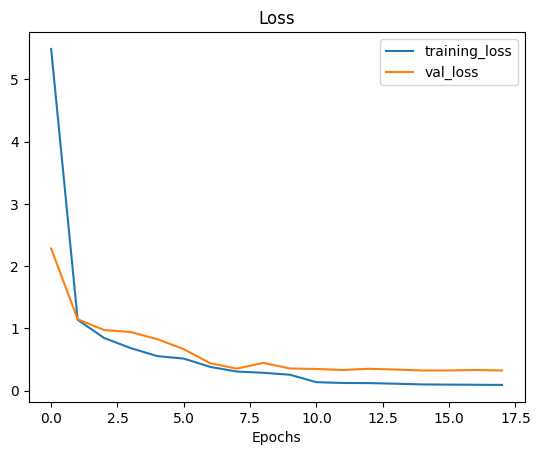

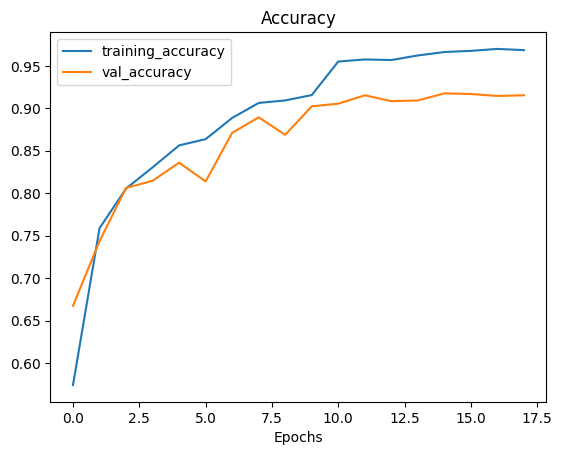

In [ ]:
plot_loss_curves(history_2)

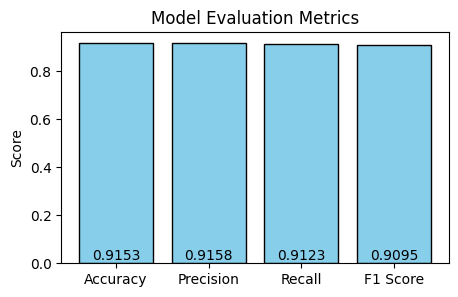

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [results_2[1], results_2[2], results_2[3], results_2[4]]

fig, ax = plt.subplots(figsize=(5, 3))

bars = ax.bar(np.arange(len(metrics)), values, color='skyblue', edgecolor='black')

ax.set_xticks(np.arange(len(metrics)))
ax.set_xticklabels(metrics)

# Display values at the bottom of each bar
for bar, value in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width() / 2, 0, f'{value:.4f}', ha='center', va='bottom', color='black', fontsize=10)

ax.set_ylabel('Score')
ax.set_title('Model Evaluation Metrics')

plt.show()

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  layers.Rescaling(1./255)
], name ="data_augmentation")

In [ ]:
from tensorflow.keras import layers

input_shape = (224, 224, 3)

base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)

outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_3 = tf.keras.Model(inputs, outputs)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# What layers in the model are trainable?
for layer in model_3.layers:
  print(layer.name, layer.trainable)

input_layer True
inception_v3 True
pooling_layer True
dense_2 True
softmax_float32 True


In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d_3 False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_4 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 Fal

In [ ]:
model_3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score(average='macro')])

In [ ]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 2048)              0         
 gePooling2D)                                                    
                                                                 
 dense_2 (Dense)             (None, 4)                 8196      
                                                                 
 softmax_float32 (Activatio  (None, 4)                 0         
 n)                                                              
                                                           

In [ ]:
# Start to fine-tune
history_3 = model_3.fit(train_data,
                      epochs=100,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      # validation_steps=int(0.15 * len(test_data)),
                      callbacks=[create_tensorboard_callback("training_logs", "inception_v3_all_data_fine_tuning"),
                                  model_checkpoint,
                                  early_stopping,
                                  reduce_lr])

Saving TensorBoard log files to: training_logs/inception_v3_all_data_fine_tuning/20240105-063220
Epoch 1/100
179/179 [==============================] - 33s 140ms/step - loss: 3.4678 - accuracy: 0.3958 - precision_2: 0.3992 - recall_2: 0.3798 - f1_score: 0.3871 - val_loss: 2.3516 - val_accuracy: 0.4981 - val_precision_2: 0.5101 - val_recall_2: 0.4821 - val_f1_score: 0.4882 - lr: 1.0000e-04
Epoch 2/100
179/179 [==============================] - 21s 113ms/step - loss: 1.6210 - accuracy: 0.5694 - precision_2: 0.5840 - recall_2: 0.5516 - f1_score: 0.5586 - val_loss: 1.7535 - val_accuracy: 0.5614 - val_precision_2: 0.5719 - val_recall_2: 0.5400 - val_f1_score: 0.5448 - lr: 1.0000e-04
Epoch 3/100
179/179 [==============================] - 19s 104ms/step - loss: 1.2960 - accuracy: 0.6305 - precision_2: 0.6465 - recall_2: 0.6153 - f1_score: 0.6193 - val_loss: 1.4684 - val_accuracy: 0.6133 - val_precision_2: 0.6225 - val_recall_2: 0.5912 - val_f1_score: 0.6009 - lr: 1.0000e-04
Epoch 4/100
179/17

In [ ]:
results_3 = model_3.evaluate(test_data)
results_3

41/41 [==============================] - 3s 72ms/step - loss: 0.4807 - accuracy: 0.8230 - precision_2: 0.8327 - recall_2: 0.8124 - f1_score: 0.8141


[0.480707585811615,
 0.8230358362197876,
 0.8326817750930786,
 0.8123570084571838,
 0.8141302466392517]

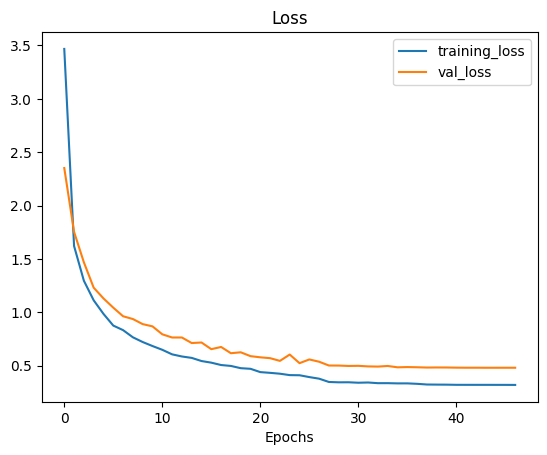

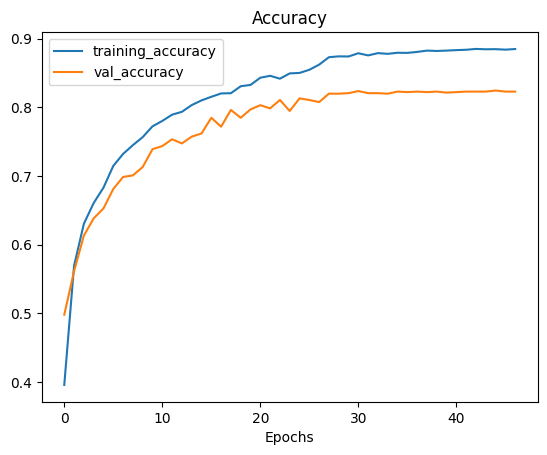

In [ ]:
plot_loss_curves(history_3)

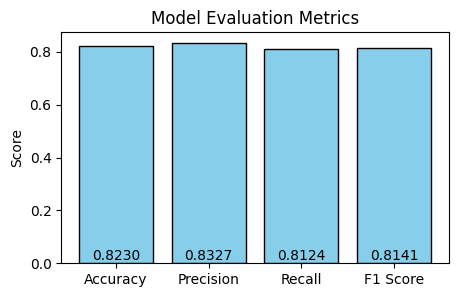

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [results_3[1], results_3[2], results_3[3], results_3[4]]

fig, ax = plt.subplots(figsize=(5, 3))

bars = ax.bar(np.arange(len(metrics)), values, color='skyblue', edgecolor='black')

ax.set_xticks(np.arange(len(metrics)))
ax.set_xticklabels(metrics)

# Display values at the bottom of each bar
for bar, value in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width() / 2, 0, f'{value:.4f}', ha='center', va='bottom', color='black', fontsize=10)

ax.set_ylabel('Score')
ax.set_title('Model Evaluation Metrics')

plt.show()

In [ ]:
from tensorflow.keras import layers

input_shape = (224, 224, 3)

base_model = tf.keras.applications.densenet.DenseNet121(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_4 = tf.keras.Model(inputs, outputs)

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# What layers in the model are trainable?
for layer in model_4.layers:
  print(layer.name, layer.trainable)

input_layer True
densenet121 True
pooling_layer True
dense_3 True
softmax_float32 True


In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_1_

In [ ]:
model_4.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score(average='macro')])

In [ ]:
model_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, None, None, 1024   7037504   
                             )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1024)              0         
 gePooling2D)                                                    
                                                                 
 dense_3 (Dense)             (None, 4)                 4100      
                                                                 
 softmax_float32 (Activatio  (None, 4)                 0         
 n)                                                              
                                                           

In [ ]:
# Start to fine-tune
history_4 = model_4.fit(train_data,
                      epochs=100,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      # validation_steps=int(0.15 * len(test_data)),
                      callbacks=[create_tensorboard_callback("training_logs", "densenet121_all_data_fine_tuning"),
                                  model_checkpoint,
                                  early_stopping,
                                  reduce_lr])

Saving TensorBoard log files to: training_logs/densenet121_all_data_fine_tuning/20240105-065329
Epoch 1/100
179/179 [==============================] - 43s 175ms/step - loss: 1.6350 - accuracy: 0.4474 - precision_3: 0.5018 - recall_3: 0.3396 - f1_score: 0.4198 - val_loss: 1.2249 - val_accuracy: 0.5187 - val_precision_3: 0.6102 - val_recall_3: 0.3822 - val_f1_score: 0.4823 - lr: 1.0000e-04
Epoch 2/100
179/179 [==============================] - 23s 125ms/step - loss: 0.9135 - accuracy: 0.6454 - precision_3: 0.7306 - recall_3: 0.4939 - f1_score: 0.6314 - val_loss: 0.9755 - val_accuracy: 0.6575 - val_precision_3: 0.7266 - val_recall_3: 0.5210 - val_f1_score: 0.6377 - lr: 1.0000e-04
Epoch 3/100
179/179 [==============================] - 23s 124ms/step - loss: 0.7308 - accuracy: 0.7319 - precision_3: 0.8073 - recall_3: 0.6181 - f1_score: 0.7216 - val_loss: 0.8829 - val_accuracy: 0.7170 - val_precision_3: 0.7745 - val_recall_3: 0.6026 - val_f1_score: 0.6978 - lr: 1.0000e-04
Epoch 4/100
179/179

In [ ]:
results_4 = model_4.evaluate(test_data)
results_4

41/41 [==============================] - 4s 92ms/step - loss: 0.3190 - accuracy: 0.8940 - precision_3: 0.8995 - recall_3: 0.8802 - f1_score: 0.8877


[0.31896522641181946,
 0.8939740657806396,
 0.8994544148445129,
 0.8802440762519836,
 0.8876913785934448]

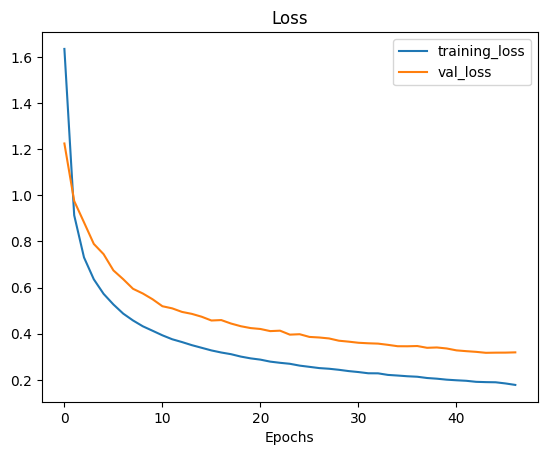

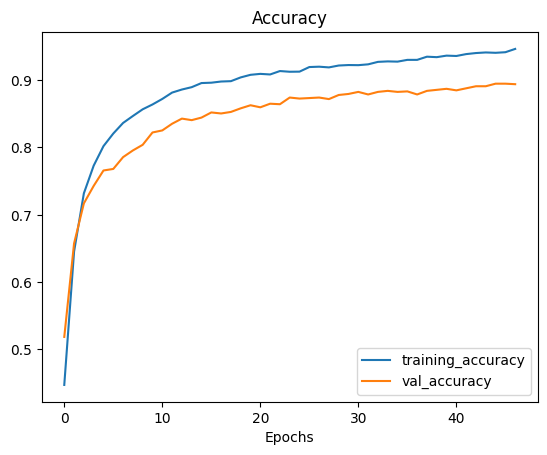

In [ ]:
plot_loss_curves(history_4)

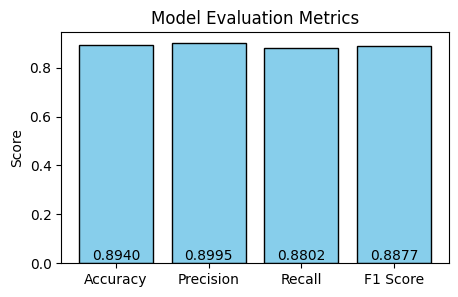

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [results_4[1], results_4[2], results_4[3], results_4[4]]

fig, ax = plt.subplots(figsize=(5, 3))

bars = ax.bar(np.arange(len(metrics)), values, color='skyblue', edgecolor='black')

ax.set_xticks(np.arange(len(metrics)))
ax.set_xticklabels(metrics)

# Display values at the bottom of each bar
for bar, value in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width() / 2, 0, f'{value:.4f}', ha='center', va='bottom', color='black', fontsize=10)

ax.set_ylabel('Score')
ax.set_title('Model Evaluation Metrics')

plt.show()

### Comparing All the Models

We are comparing all of our Models in terms of following Metrics:
- Accuracy
- Precision
- Recall
- F1-Score



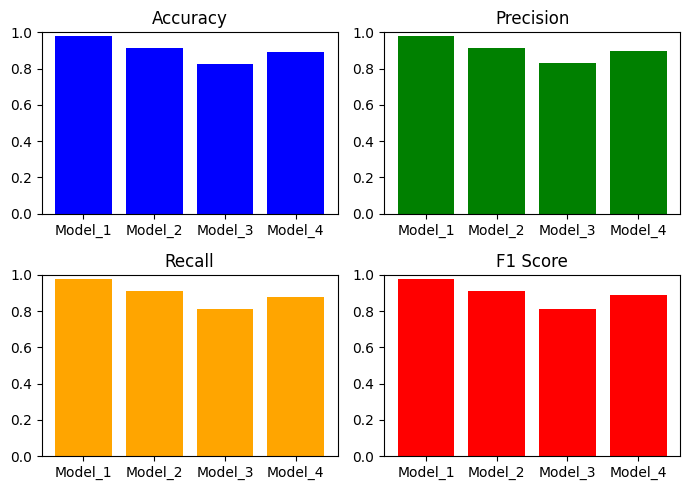

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
results = [results_1, results_2, results_3, results_4]

# Extracting data for plotting
model_names = ["Model_1", "Model_2", "Model_3", "Model_4"]
accuracy_values = [result[1] for result in results]
precision_values = [result[2] for result in results]
recall_values = [result[3] for result in results]
f1_score_values = [result[4] for result in results]

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(7, 5))

# Plotting Accuracy
axs[0, 0].bar(model_names, accuracy_values, color='blue')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_ylim([0, 1])

# Plotting Precision
axs[0, 1].bar(model_names, precision_values, color='green')
axs[0, 1].set_title('Precision')
axs[0, 1].set_ylim([0, 1])

# Plotting Recall
axs[1, 0].bar(model_names, recall_values, color='orange')
axs[1, 0].set_title('Recall')
axs[1, 0].set_ylim([0, 1])

# Plotting F1 Score
axs[1, 1].bar(model_names, f1_score_values, color='red')
axs[1, 1].set_title('F1 Score')
axs[1, 1].set_ylim([0, 1])

# Adjusting layout
plt.tight_layout()

# Display the plot
plt.show()

### Saving Best Model


In [ ]:
# Saving our best model

model_path = "drive/My Drive/Data/models/saved_trained_model.h5"
print(f"Saving model to: {model_path}...")
model_1.save(model_path)

Saving model to: drive/My Drive/Data/models/saved_trained_model.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Loading Our Saved Model



Uploading an MRI image of a patient and utilizing it for predictive analysis

In [ ]:
# loading our model

loaded_model = tf.keras.saving.load_model("drive/My Drive/Data/models/saved_trained_model.h5")

In [ ]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [ ]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
 softmax_float32 (Activatio  (None, 4)                 0         
 n)                                                              
                                                             

Prediction on a new MRI Image

In [ ]:
# uploading any image from internet and using it for prediction
# -q is for "quiet"
!wget -q https://multiplesclerosisnewstoday.com/wp-content/uploads/2022/08/CC7C8857-F56B-4524-8E66-A5DD0D03B16F-768x1137.jpeg

1/1 [==============================] - 5s 5s/step


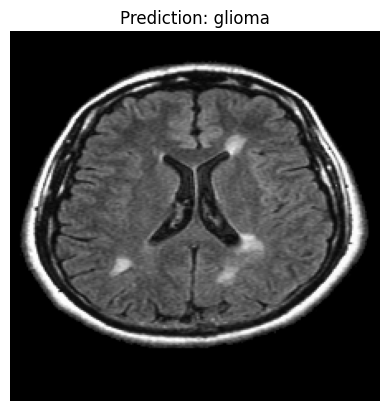

In [ ]:
# Make a prediction using model_1
pred_and_plot(model=loaded_model,
              filename="CC7C8857-F56B-4524-8E66-A5DD0D03B16F-768x1137.jpeg",
              class_names=class_names)

In [ ]:
!wget https://i.imgur.com/95CHmXb.png


--2024-01-05 18:36:20--  https://i.imgur.com/95CHmXb.png
Resolving i.imgur.com (i.imgur.com)... 146.75.92.193
Connecting to i.imgur.com (i.imgur.com)|146.75.92.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34282 (33K) [image/png]
Saving to: ‘95CHmXb.png’

95CHmXb.png         100%[===================>]  33.48K  --.-KB/s    in 0.003s  

2024-01-05 18:36:20 (10.2 MB/s) - ‘95CHmXb.png’ saved [34282/34282]



1/1 [==============================] - 0s 45ms/step


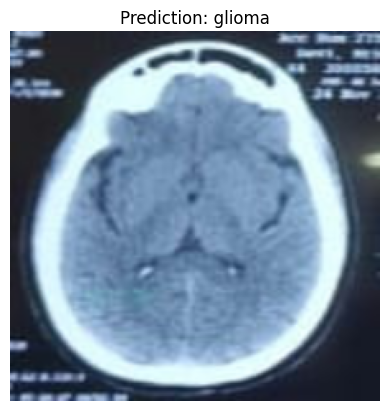

In [ ]:
# Make a prediction using model_1
pred_and_plot(model=loaded_model,
              filename="95CHmXb.png",
              class_names=class_names)